In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re

from utils import *

I take a curriculum approach to training here. I first expose the model to as many different images of whales as quickly as possible (no oversampling) and train on images resized to 224x224.

I would like the conv layers to start picking up on features useful for identifying whales. For that, I want to show the model as rich of a dataset as possible.

I then train on images resized to 448x448.

Finally, I train on oversampled data. Here, the model will see some images more often than others but I am hoping that this will help alleviate the class imbalance in the training data.

In [2]:
import fastai
from fastprogress import force_console_behavior
import fastprogress
fastprogress.fastprogress.NO_BAR = True
master_bar, progress_bar = force_console_behavior()
fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

In [3]:
df = pd.read_csv('data/train.csv')
val_fns = {'69823499d.jpg'}

In [4]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [5]:
#KL: name = f'res50-full-train'
name = f'res50-full-train-bbox'

In [6]:
SZ = 224
BS = 64
NUM_WORKERS = 8
SEED=0

In [7]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], 'data/train-bbox-224', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder('data/test-bbox-224'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

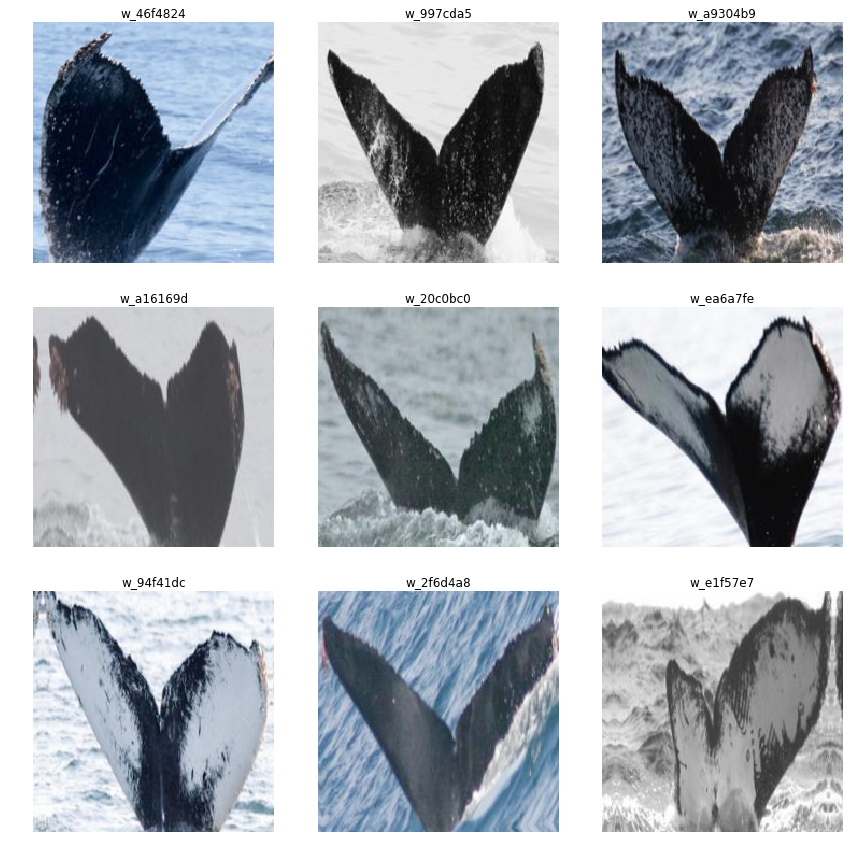

In [8]:
data.show_batch(rows=3, ds_type=DatasetType.Train, figsize=(12,12))

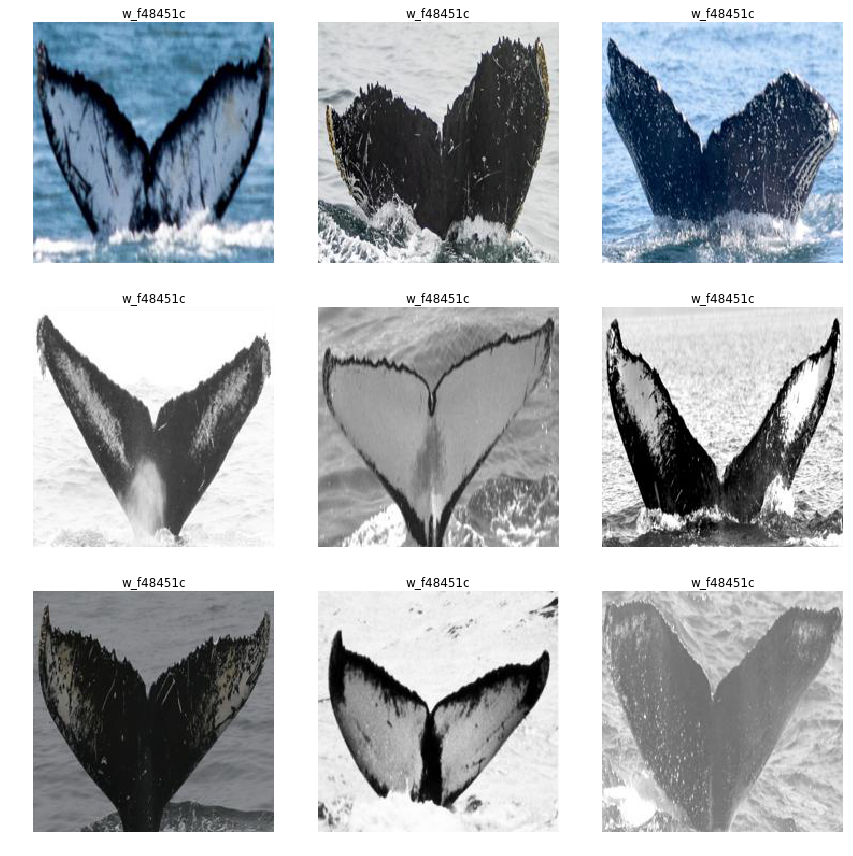

In [ ]:
data.show_batch(rows=3, ds_type=DatasetType.Test, figsize=(12,12))

In [ ]:
%%time

#KL: Original code, res50-full-train-stage-2: t=1:20hr, leaderboard=0.542, train_loss=0.0291
#KL: Add bbox, res50-full-train-bbox-stage-2: t=1:14hr, leaderboard=0.XXX, train_loss=0.0219

learn = create_cnn(data, models.resnet50, lin_ftrs=[2048])
learn.clip_grad();

learn.fit_one_cycle(14, 1e-2)
learn.save(f'{name}-stage-1')

learn.unfreeze()

max_lr = 1e-3
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(24, lrs)
learn.save(f'{name}-stage-2')

epoch     train_loss  valid_loss
1         7.456321    0.667319    
2         6.390104    0.111538    
3         5.775140    0.664557    
4         4.849987    0.762108    
5         3.900450    0.001728    
6         3.024649    0.001700    
7         2.167927    0.014175    
8         1.517842    0.005787    
9         0.858780    0.000022    
10        0.498746    0.000001    
11        0.297396    0.000018    
12        0.161731    0.000049    


In [9]:
SZ = 224 * 2
BS = 64 // 4
NUM_WORKERS = 8
SEED=0

In [10]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], 'data/train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [ ]:
%%time
learn = create_cnn(data, models.resnet50, lin_ftrs=[2048])
learn.clip_grad();
learn.load(f'{name}-stage-2')
learn.freeze_to(-1)

learn.fit_one_cycle(12, 1e-2 / 4)
learn.save(f'{name}-stage-3')

learn.unfreeze()

max_lr = 1e-3 / 4
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(22, lrs)
learn.save(f'{name}-stage-4')

epoch     train_loss  valid_loss
1         1.215888    0.000000    
2         0.903646    0.000000    
3         1.237794    0.000000    
4         1.775880    0.000000    
5         1.740799    0.000013    
6         1.737962    0.000000    
7         1.508887    0.000000    
8         1.338434    0.000000    
9         1.064585    0.000000    
10        0.792885    0.000000    
11        0.623106    0.000000    
12        0.507520    0.000000    
epoch     train_loss  valid_loss
1         0.510431    0.000000    
2         0.519994    0.000000    
3         0.563116    0.000000    
4         0.601170    0.000000    
5         0.715552    0.000000    
6         0.672135    0.000000    
7         0.719716    0.000001    
8         0.707234    0.000000    
9         0.693418    0.000000    
10        0.761318    0.000000    
11        0.654415    0.000002    
12        0.640656    0.000000    
13        0.625035    0.000001    
14        0.541348    0.000000    
15        0.480400    0.

In [14]:
# with oversampling
df = pd.read_csv('data/oversampled_train_and_val.csv')

In [15]:
data = (
    ImageItemList
        .from_df(df, 'data/train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [17]:
%%time
learn = create_cnn(data, models.resnet50, lin_ftrs=[2048])
learn.clip_grad();
learn.load(f'{name}-stage-4')
learn.freeze_to(-1)

learn.fit_one_cycle(2, 1e-2 / 4)
learn.save(f'{name}-stage-5')

learn.unfreeze()

max_lr = 1e-3 / 4
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(3, lrs)
learn.save(f'{name}-stage-6')

#KL: Running this entire notebook with no changes take ~6.5hrs and scores 0.636 on Kaggle with train_loss = 0.0114 and valid_loss = 0

epoch     train_loss  valid_loss
1         0.150589    0.000073    
2         0.042597    0.000000    
epoch     train_loss  valid_loss
1         0.028951    0.000000    
2         0.017873    0.000000    
3         0.011447    0.000000    
CPU times: user 32min 53s, sys: 13min 17s, total: 46min 11s
Wall time: 50min 39s


In [ ]:
#KL: Add bbox training


## Predict

In [10]:
#KL: Uncomment these and change the name if you need to load your model because you aren't submitting right after training
learn = create_cnn(data, models.resnet50, lin_ftrs=[2048])
learn.clip_grad();
learn.load('res50-full-train-bbox-stage-2')

preds, _ = learn.get_preds(DatasetType.Test)

In [11]:
preds = torch.cat((preds, torch.ones_like(preds[:, :1])), 1)

In [12]:
preds[:, 5004] = 0.06

In [13]:
classes = learn.data.classes + ['new_whale']

In [14]:
#KL: If this fails, it might be because the directory 'subs' is missing and you need to make it
create_submission(preds, learn.data, name, classes)

In [15]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,Image,Id
0,68f340d0c.jpg,w_bc285a6 new_whale w_e79b4d0 w_c7e2a65 w_a2158b8
1,e630231e9.jpg,w_c178f34 w_df1cc01 w_7e9ae57 w_14e5fe2 new_whale
2,ede743c5f.jpg,w_8d9d59a new_whale w_fa7cd91 w_c16cb2c w_40a6c9c
3,23877c73f.jpg,w_46796cc new_whale w_99af1a9 w_356b5b7 w_cb622a2
4,ad3afe7cb.jpg,w_6e7cf1c w_50fd107 new_whale w_7206ab2 w_f75ed58


In [16]:
pd.read_csv(f'subs/{name}.csv.gz').Id.str.split().apply(lambda x: x[0] == 'new_whale').mean()

0.0025125628140703518

In [17]:
!kaggle competitions submit -c humpback-whale-identification -f subs/{name}.csv.gz -m "{name}"

100%|█████████████████████████████████████████| 184k/184k [00:01<00:00, 168kB/s]
Successfully submitted to Humpback Whale Identification